**Covid-19 Sentiment Analysis**

**Context**

I collect recent tweets about the COVID-19 vaccines used in entire world on large scale, as following:

- Pfizer/BioNTech;
- Sinopharm;
- Sinovac;
- Moderna;
- Oxford/AstraZeneca;
- Covaxin;
- Sputnik V.

**Data collection**

The data is collected using tweepy Python package to access Twitter API. For each of the vaccine I use relevant search term (most frequently used in Twitter to refer to the respective vaccine)

**Data collection frequency**

Initial data was merged from tweets about Pfizer/BioNTech vaccine. I added then tweets from Sinopharm, Sinovac (both Chinese-produced vaccines), Moderna, Oxford/Astra-Zeneca, Covaxin and Sputnik V vaccines. The collection was in the first days twice a day, until I identified approximatively the new tweets quota and then collection (for all vaccines) stabilized at once a day, during morning hours (GMT).

**Inspiration**

You can perform multiple operations on the vaccines tweets. Here are few possible suggestions:

- Study the subjects of recent tweets about the vaccine made by various producers;
- Perform various NLP tasks on this data source (topic modelling, sentiment analysis);
- Using the COVID-19 World Vaccination Progress (where we can see the progress of the vaccinations and the countries where the vaccines are administered), you can study the relationship between the vaccination progress and the discussions in social media (from the tweets) about the vaccines.



*Kaggle Dataset*
- https://www.kaggle.com/c/tweet-sentiment-extraction

- https://www.kaggle.com/gpreda/all-covid19-vaccines-tweets



---
**Load Packages**

In [1]:
import warnings
warnings.simplefilter("ignore")

import re
import numpy as np 
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

import gensim  # https://pypi.org/project/gensim/
import nltk #https://www.nltk.org/
from nltk.sentiment import SentimentIntensityAnalyzer #https://www.nltk.org/api/nltk.sentiment.html
from textblob import TextBlob #https://textblob.readthedocs.io/en/dev/
from wordcloud import WordCloud, STOPWORDS #https://pypi.org/project/wordcloud/

from nltk.stem import WordNetLemmatizer
from nltk.stem import LancasterStemmer
from nltk.tokenize.treebank import TreebankWordDetokenizer

import tensorflow as tf
import plotly.express as px


In [2]:
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem import LancasterStemmer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import gensim
from sklearn.model_selection import train_test_split
import spacy
import pickle
from keras.preprocessing.text import Tokenizer
#for confusion matrix
import seaborn
from sklearn.metrics import confusion_matrix
import keras

Load the Dataset vaccination_all_tweets.csv 

In [3]:
tweets_df = pd.read_csv('update_vaccination_all_tweets.csv')
tweets_df.head(10)

id             user_name                user_location  \
0  1340539111971516416            Rachel Roh    La Crescenta-Montrose, CA   
1  1338158543359250433           Albert Fong            San Francisco, CA   
2  1337858199140118533              eli🇱🇹🇪🇺👌                     Your Bed   
3  1337855739918835717         Charles Adler       Vancouver, BC - Canada   
4  1337854064604966912  Citizen News Channel                          NaN   
5  1337852648389832708                   Dee          Birmingham, England   
6  1337851215875608579     Gunther Fehlinger  Austria, Ukraine and Kosovo   
7  1337850832256176136   Dr.Krutika Kuppalli                          NaN   
8  1337850023531347969           Erin Despas                          NaN   
9  1337842295857623042          Ch.Amjad Ali                    Islamabad   

                                    user_description         user_created  \
0  Aggregator of Asian American news; scanning di...  2009-04-08 17:52:46   
1  Marketing dude, tech geek, heavy metal & '80s ...  2009-09-21 15:27:30   
2                                     heil, hydra 🖐☺  2020-06-25 23:30:28   
3  Hosting "CharlesAdlerTonight" Global News Radi...  2008-09-10 11:28:53   
4  Citizen News Channel bringing you an alternati...  2020-04-23 17:58:42   
5  Gastroenterology trainee, Clinical Research Fe...  2020-01-26 21:43:12   
6  End North Stream 2 now - the pipeline of corru...  2013-06-10 17:49:22   
7  ID, Global Health, VHF, Pandemic Prep, Emergin...  2019-03-25 04:14:29   
8  Designing&selling on Teespring. Like 90s Disne...  2009-10-30 17:53:54   
9  #ProudPakistani #LovePakArmy #PMIK @insafiansp...  2012-11-12 04:18:12   

   user_followers  user_friends  user_favourites  user_verified  \
0             405          1692             3247          False   
1             834           666              178          False   
2              10            88              155          False   
3           49165          3933            21853           True   
4             152           580             1473          False   
5             105           108              106          False   
6            2731          5001            69344          False   
7           21924           593             7815           True   
8             887          1515             9639          False   
9             671          2368            20469          False   

                  date                                               text  \
0  2020-12-20 06:06:44  Same folks said daikon paste could treat a cyt...   
1  2020-12-13 16:27:13  While the world has been on the wrong side of ...   
2  2020-12-12 20:33:45  #coronavirus #SputnikV #AstraZeneca #PfizerBio...   
3  2020-12-12 20:23:59  Facts are immutable, Senator, even when you're...   
4  2020-12-12 20:17:19  Explain to me again why we need a vaccine @Bor...   
5  2020-12-12 20:11:42  Does anyone have any useful advice/guidance fo...   
6  2020-12-12 20:06:00  it is a bit sad to claim the fame for success ...   
7  2020-12-12 20:04:29  There have not been many bright days in 2020 b...   
8  2020-12-12 20:01:16  Covid vaccine; You getting it?\n\n #CovidVacci...   
9  2020-12-12 19:30:33  #CovidVaccine \n\nStates will start getting #C...   

                                            hashtags               source  \
0                                 ['PfizerBioNTech']  Twitter for Android   
1                                                NaN      Twitter Web App   
2  ['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...  Twitter for Android   
3                                                NaN      Twitter Web App   
4     ['whereareallthesickpeople', 'PfizerBioNTech']   Twitter for iPhone   
5                                                NaN   Twitter for iPhone   
6                                    ['vaccination']      Twitter Web App   
7                    ['BidenHarris', 'Election2020']   Twitter for iPhone   
8  ['CovidVaccine', 'covid19', 'PfizerBioNTec

In [4]:
print(f'The Dataset shape is:',tweets_df.shape)

The Dataset shape is: (125906, 16)


So we have 125906 rows and 16 columns

In [5]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125906 entries, 0 to 125905
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                125906 non-null  int64 
 1   user_name         125906 non-null  object
 2   user_location     89972 non-null   object
 3   user_description  116829 non-null  object
 4   user_created      125906 non-null  object
 5   user_followers    125906 non-null  int64 
 6   user_friends      125906 non-null  int64 
 7   user_favourites   125906 non-null  int64 
 8   user_verified     125906 non-null  bool  
 9   date              125906 non-null  object
 10  text              125906 non-null  object
 11  hashtags          101894 non-null  object
 12  source            125787 non-null  object
 13  retweets          125906 non-null  int64 
 14  favorites         125906 non-null  int64 
 15  is_retweet        125906 non-null  bool  
dtypes: bool(2), int64(6), object(8)
memory

In [6]:
tweets_df.describe()

id  user_followers   user_friends  user_favourites  \
count  1.259060e+05    1.259060e+05  125906.000000     1.259060e+05   
mean   1.385793e+18    1.106664e+05    1093.166283     1.364298e+04   
std    1.740242e+16    8.887440e+05    5241.860209     4.179660e+04   
min    1.337728e+18    0.000000e+00       0.000000     0.000000e+00   
25%    1.372300e+18    1.070000e+02      80.000000     1.460000e+02   
50%    1.383376e+18    5.460000e+02     309.000000     1.623000e+03   
75%    1.402291e+18    2.092000e+03     932.000000     9.128250e+03   
max    1.410706e+18    1.578068e+07  516578.000000     1.221784e+06   

            retweets      favorites  
count  125906.000000  125906.000000  
mean        2.976872      13.274046  
std        55.194169     194.277738  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         0.000000       1.000000  
75%         1.000000       3.000000  
max     11288.000000   25724.000000

**Missing Data**

In [7]:
#Lets find out the mising data
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))


In [8]:
missing_data(tweets_df)

id user_name user_location user_description user_created  \
Total        0         0         35934             9077            0   
Percent    0.0       0.0      28.54034         7.209347          0.0   
Types    int64    object        object           object       object   

        user_followers user_friends user_favourites user_verified    date  \
Total                0            0               0             0       0   
Percent            0.0          0.0             0.0           0.0     0.0   
Types            int64        int64           int64          bool  object   

           text   hashtags    source retweets favorites is_retweet  
Total         0      24012       119        0         0          0  
Percent     0.0  19.071371  0.094515      0.0       0.0        0.0  
Types    object     object    object    int64     int64       bool

**Unique Value**

In [9]:
#Unique values
def unique_values(data):
    total = data.count()
    tt = pd.DataFrame(total)
    tt.columns = ['Total']
    
    uniques = []
    for col in data.columns:
        unique = data[col].nunique()
        uniques.append(unique)
    tt['Uniques'] = uniques
    return(np.transpose(tt))

In [10]:
unique_values(tweets_df)

id  user_name  user_location  user_description  user_created  \
Total    125906     125906          89972            116829        125906   
Uniques  125906      58117          18361             56333         59193   

         user_followers  user_friends  user_favourites  user_verified    date  \
Total            125906        125906           125906         125906  125906   
Uniques           16531          6835            29256              2  123605   

           text  hashtags  source  retweets  favorites  is_retweet  
Total    125906    101894  125787    125906     125906      125906  
Uniques  125175     38693     284       373        848           1

**Most frequent values**

In [11]:
def most_frequent_values(data):
    total = data.count()
    tt = pd.DataFrame(total)
    tt.columns = ['Total']
    items = []
    vals = []
    for col in data.columns:
        itm = data[col].value_counts().index[0]
        val = data[col].value_counts().values[0]
        items.append(itm)
        vals.append(val)
    tt['Most frequent item'] = items
    tt['Frequence'] = vals
    tt['Percent from total'] = np.round(vals / total * 100, 3)
    return(np.transpose(tt))

In [12]:
most_frequent_values(tweets_df)

id       user_name user_location  \
Total                            125906          125906         89972   
Most frequent item  1340539111971516416  CowinBangalore         India   
Frequence                             1            7462          5352   
Percent from total                0.001           5.927         5.949   

                                                     user_description  \
Total                                                          116829   
Most frequent item  Follow us to get update as soon as 18 plus vac...   
Frequence                                                        7385   
Percent from total                                              6.321   

                           user_created user_followers user_friends  \
Total                            125906         125906       125906   
Most frequent item  2021-05-17 18:56:45           1102            2   
Frequence                          7645           2031         8112   
Percent from total                6.072          1.613        6.443   

                   user_favourites user_verified                 date  \
Total                       125906        125906               125906   
Most frequent item              57         False  2021-06-18 13:13:23   
Frequence                     4991        113344                    6   
Percent from total           3.964        90.023                0.005   

                                                                 text  \
Total                                                          125906   
Most frequent item  Got my second dose of the #Moderna #vaccine to...   
Frequence                                                          16   
Percent from total                                              0.013   

                               hashtags               source retweets  \
Total                            101894               125787   125906   
Most frequent item  ['COVAXIN', 'BBMP']  Twitter for Android        0   
Frequence                          7080                35817    89829   
Percent from total                6.948               28.474   71.346   

                   favorites is_retweet  
Total                 125906     125906  
Most frequent item         0      False  
Frequence              57986     125906  
Percent from total    46.055      100.0

**Visualize the Data Distribution**

In [13]:
def plot_count(feature, title, df, size=1, ordered=True):
    f, ax = plt.subplots(1,1, figsize=(4*size,4),)
    total = float(len(df))
    if ordered:
        g = sns.countplot(df[feature], order = df[feature].value_counts().index[:20], palette='RdBu')
    else:
        g = sns.countplot(df[feature], palette='RdBu')
    g.set_title("Number and percentage of {}\n".format(title))
    if(size > 2):
        plt.xticks(rotation=90, size=10)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2. ,height, ' {:1.2f}% '.format(100*height/total), ha="center")
    plt.show()  

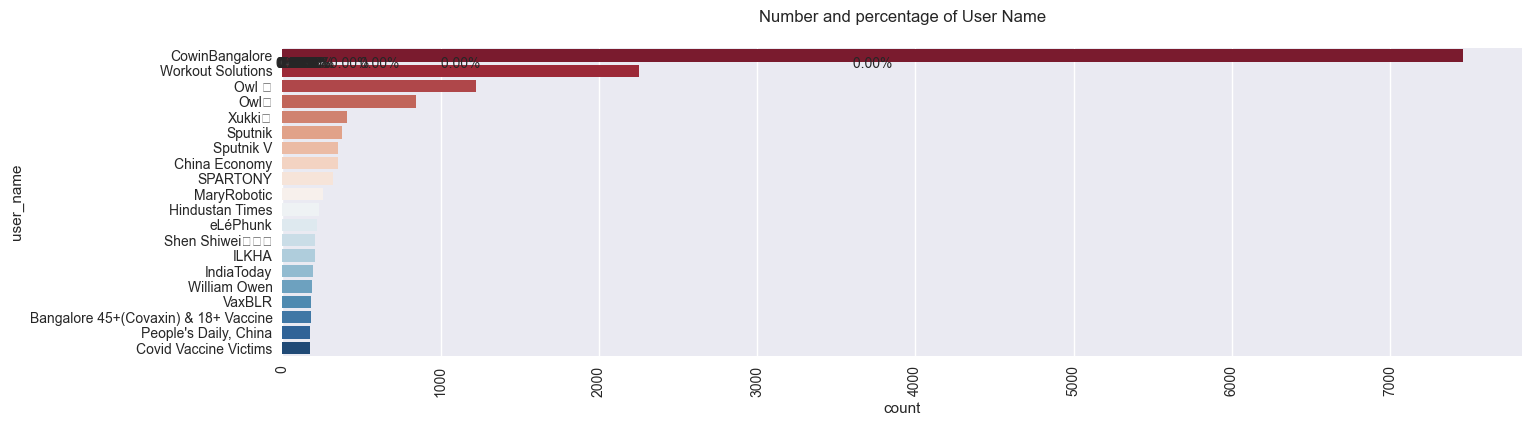

In [14]:
# User Name
plot_count('user_name' , "User Name" , tweets_df , 4)

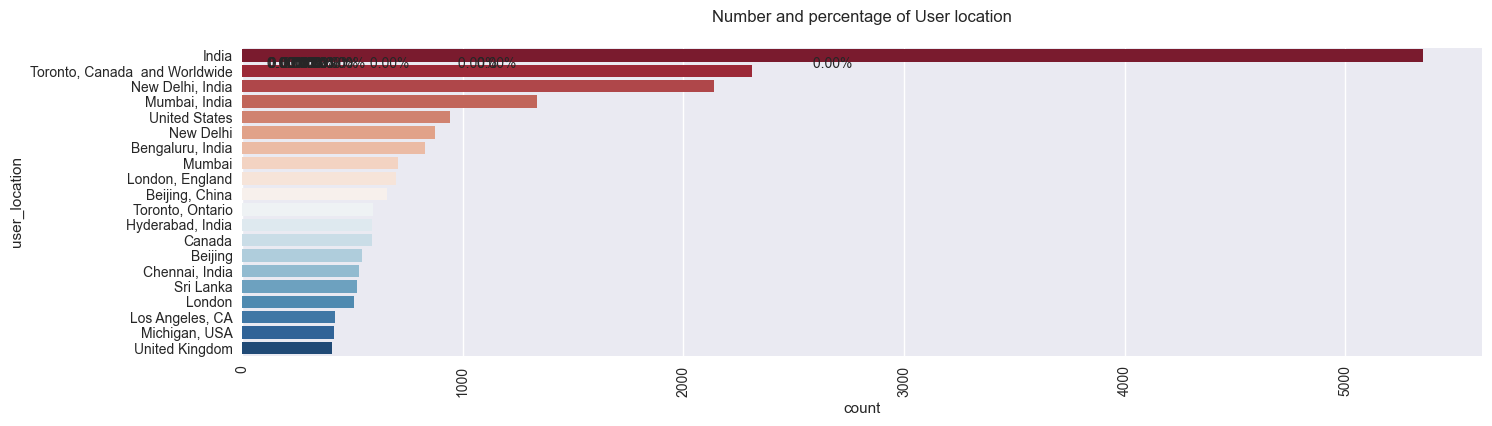

In [15]:
# User Location
plot_count("user_location", "User location", tweets_df,4)

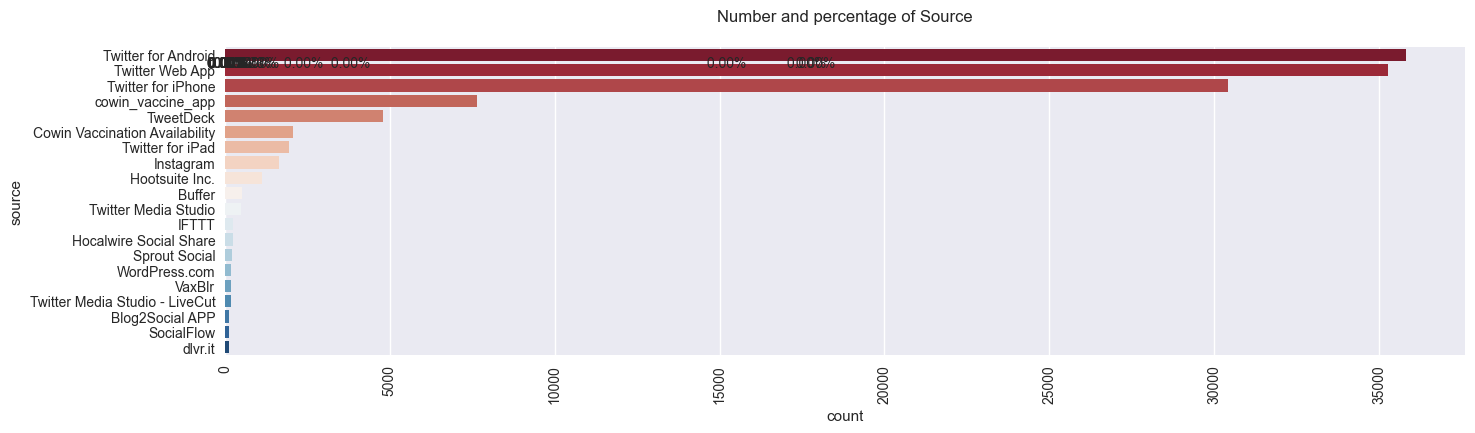

In [16]:
#Tweet Source 
plot_count("source", "Source", tweets_df,4)

**Word Cloud**

In [17]:
#Make a word Cloud from dataset
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=50,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [18]:
def show_wordcloud(data, title=""):
    text = " ".join(t for t in data.dropna())
    stopwords = set(STOPWORDS)
    stopwords.update(["t", "co", "https", "amp", "U"])
    wordcloud = WordCloud(stopwords=stopwords, scale=4, max_font_size=40, max_words=700,background_color="#002210").generate(text)
    fig = plt.figure(1, figsize=(20,20))
    plt.axis('off')
    fig.suptitle(title, fontsize=20)
    fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.style.use('ggplot')
    plt.show()

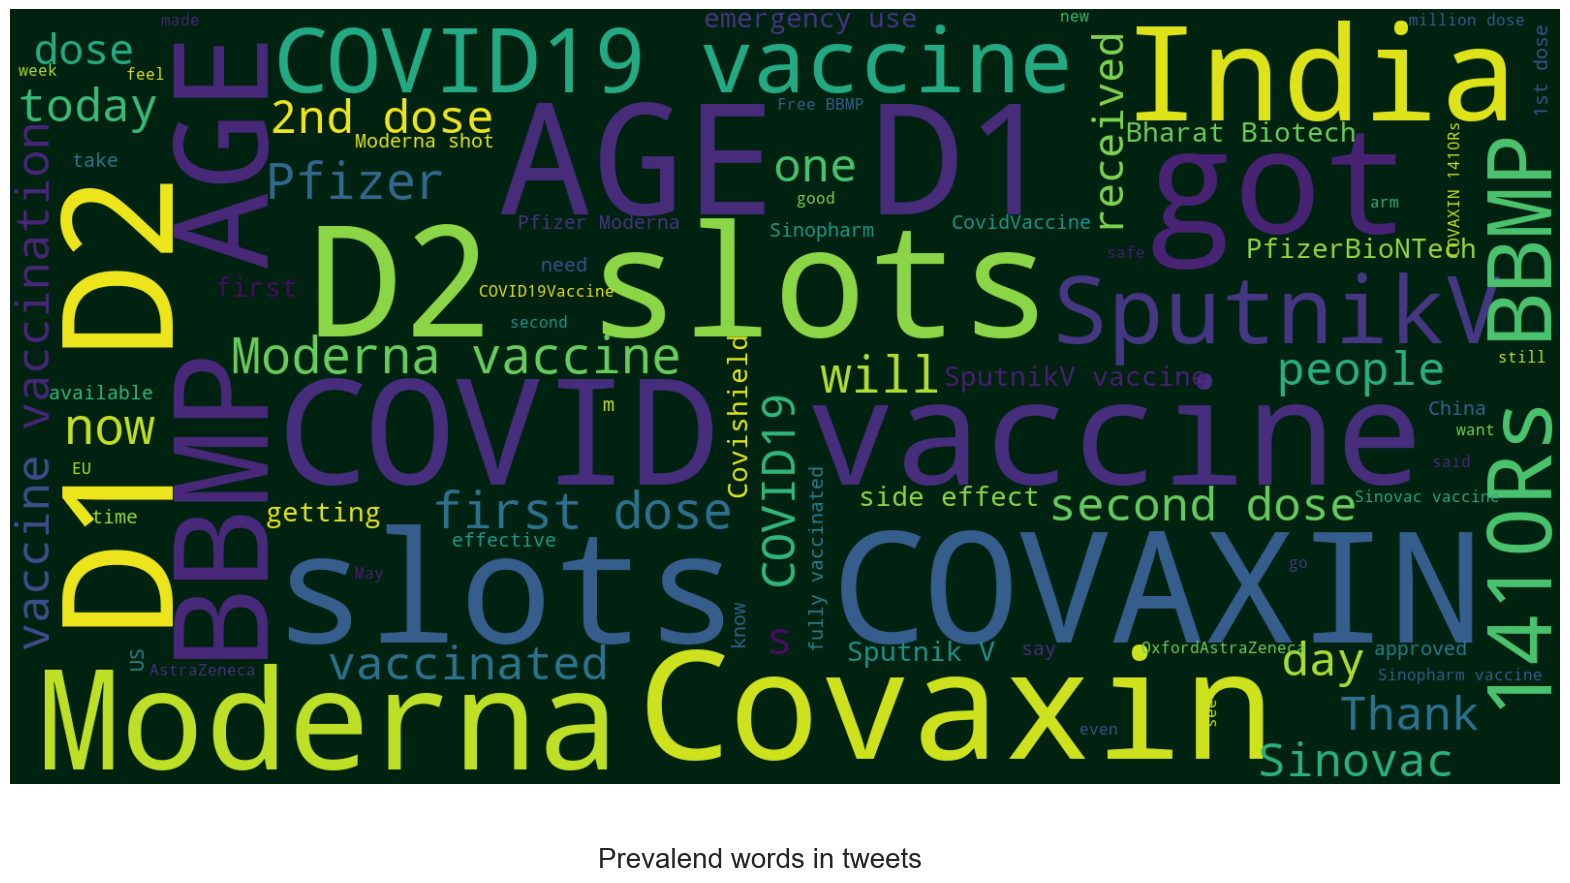

In [19]:
show_wordcloud(tweets_df['text'] , title = 'Prevalend words in tweets')

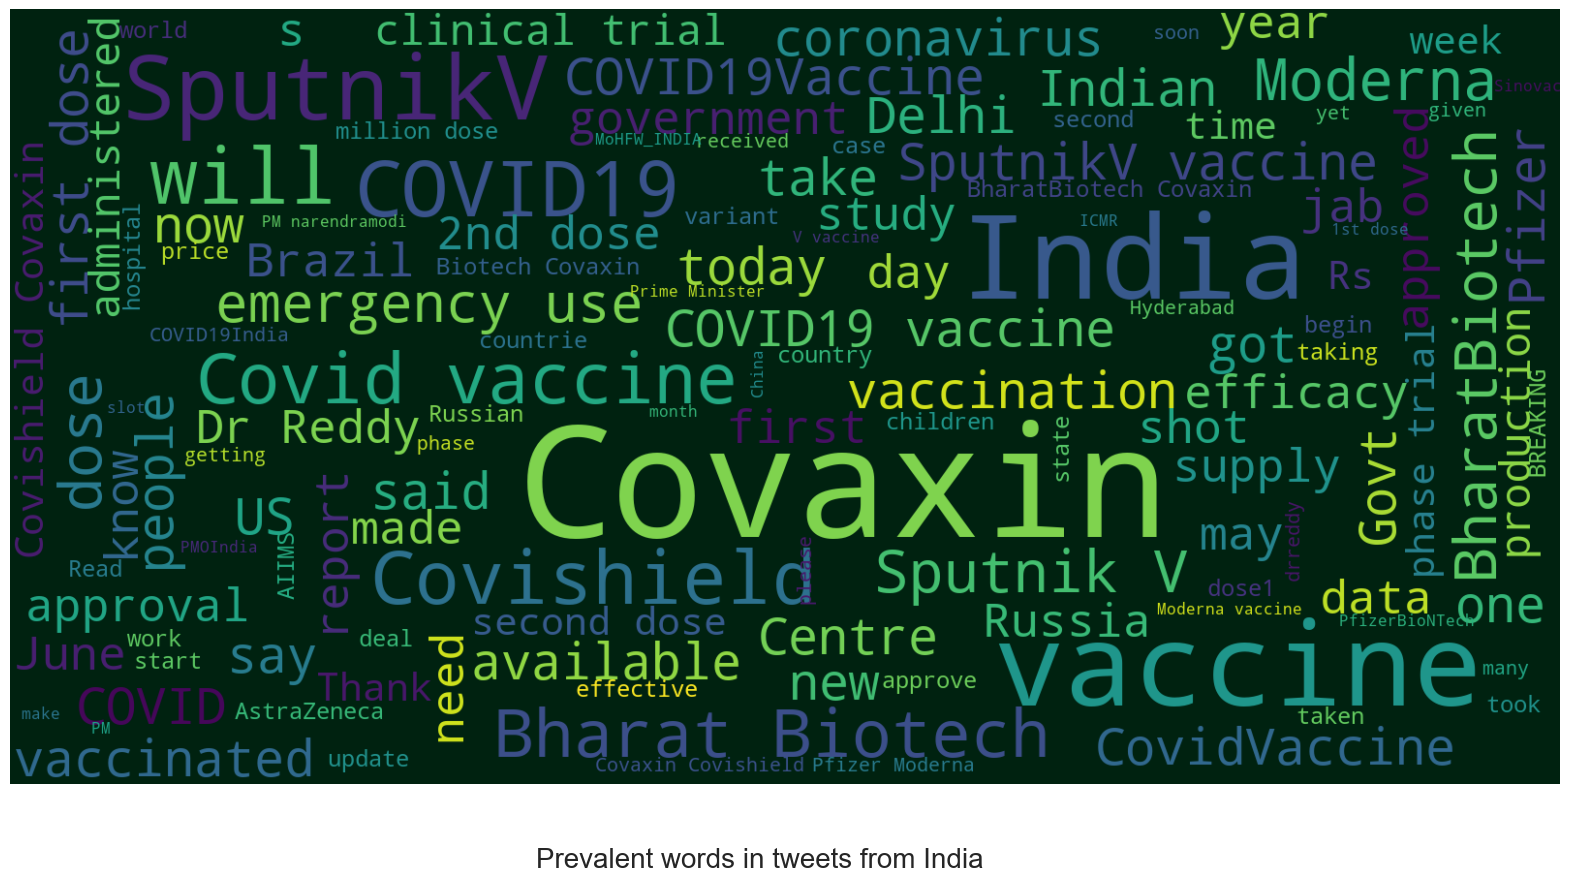

In [20]:
# India
india_df = tweets_df.loc[tweets_df.user_location=="India"]
show_wordcloud(india_df['text'], title = 'Prevalent words in tweets from India')

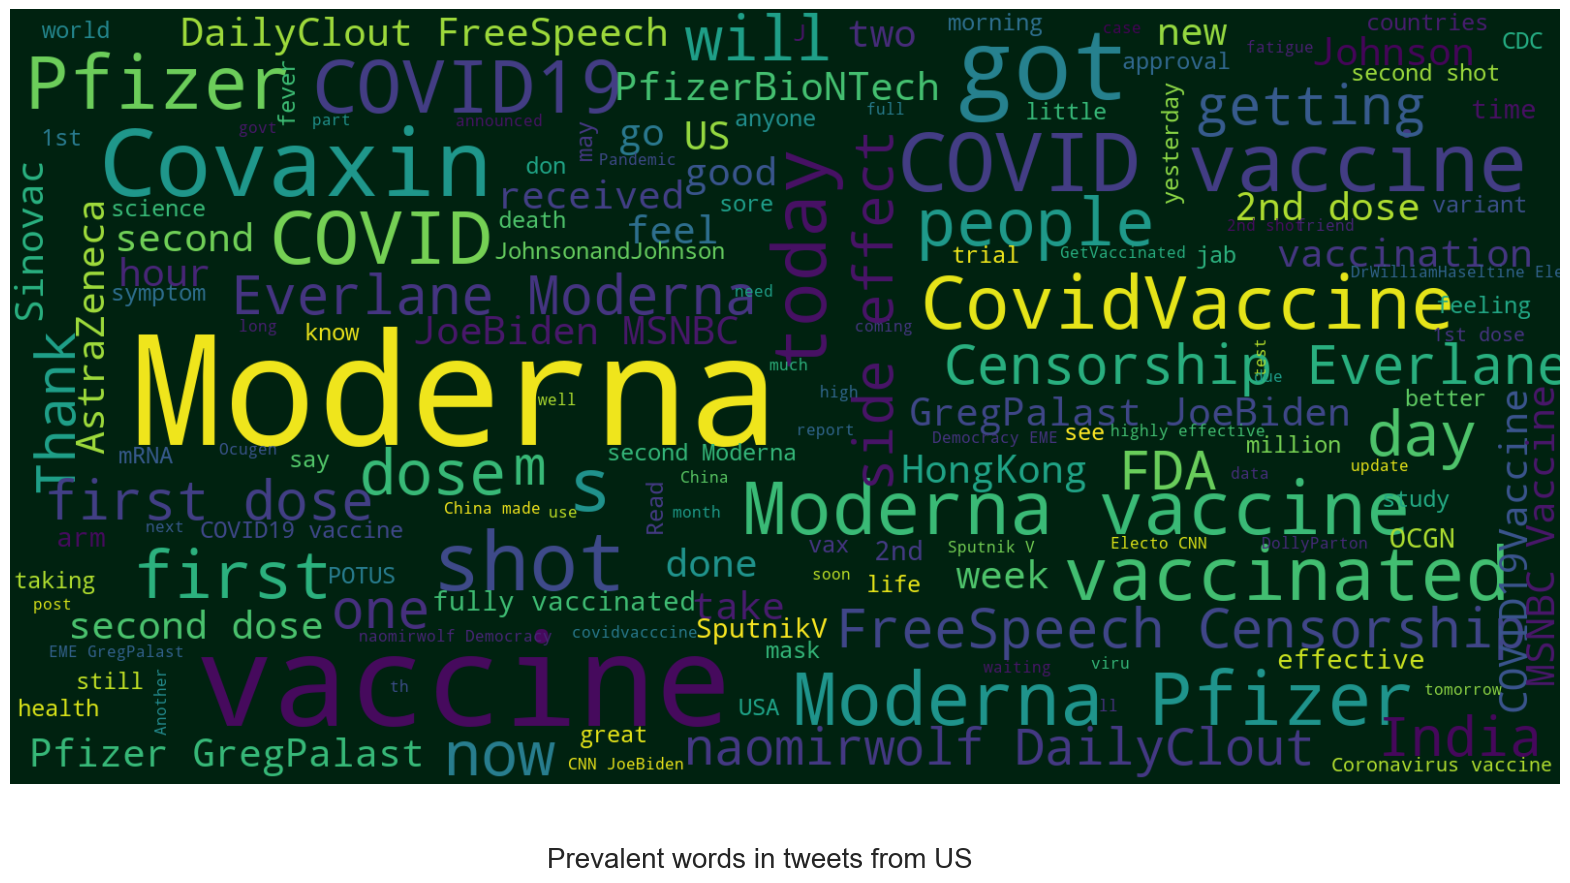

In [21]:
# From USA
us_df = tweets_df.loc[tweets_df.user_location=="United States"]
show_wordcloud(us_df['text'], title = 'Prevalent words in tweets from US')

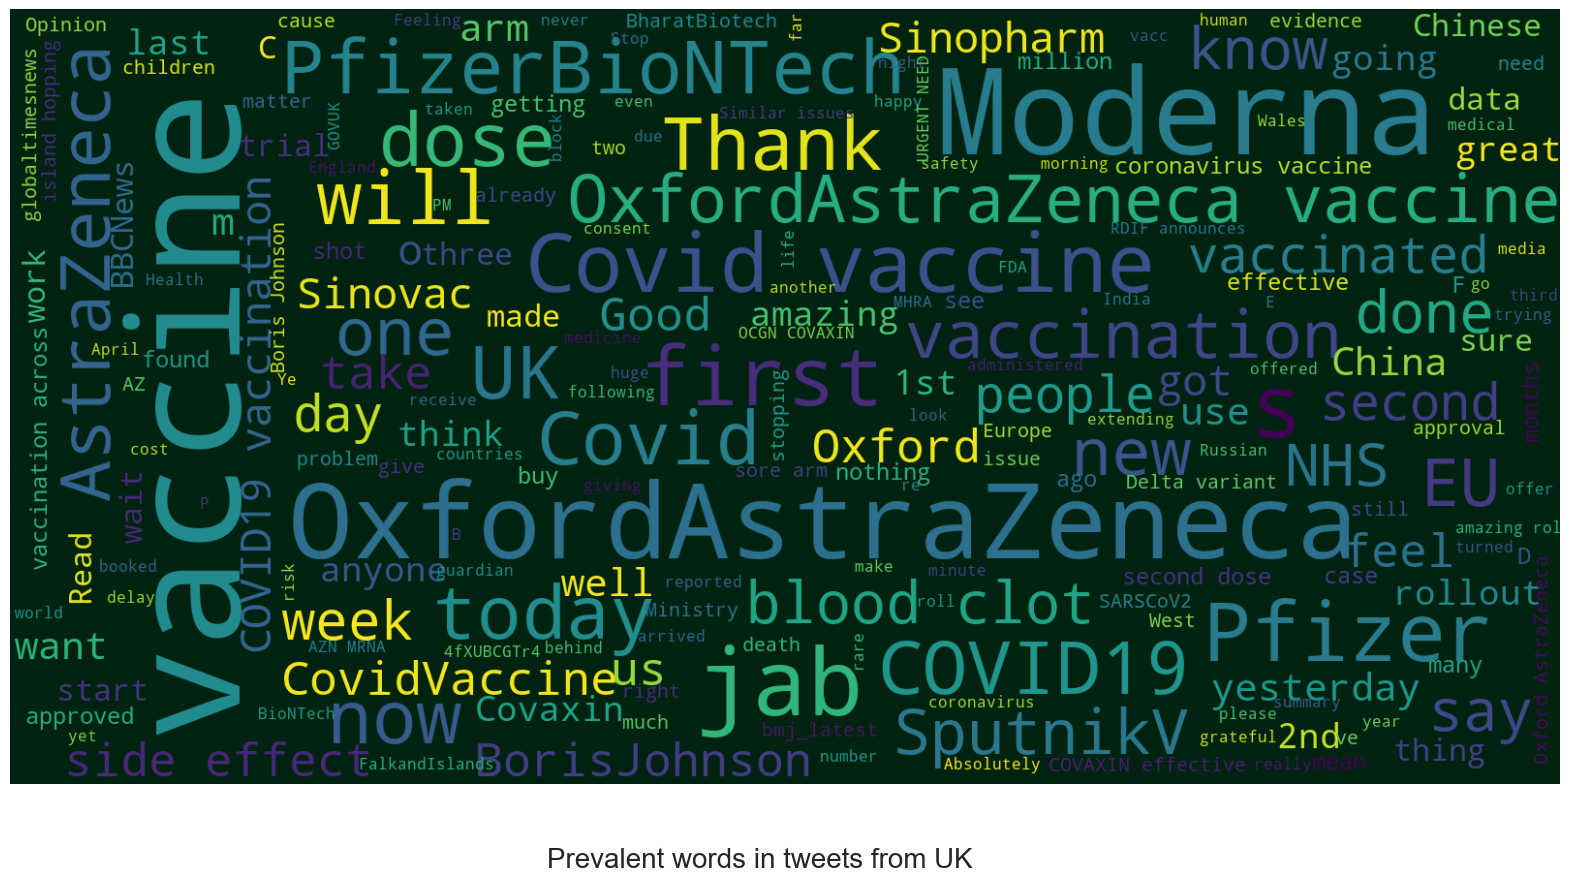

In [22]:
# From UK
uk_df = tweets_df.loc[tweets_df.user_location=="United Kingdom"]
show_wordcloud(uk_df['text'], title = 'Prevalent words in tweets from UK')

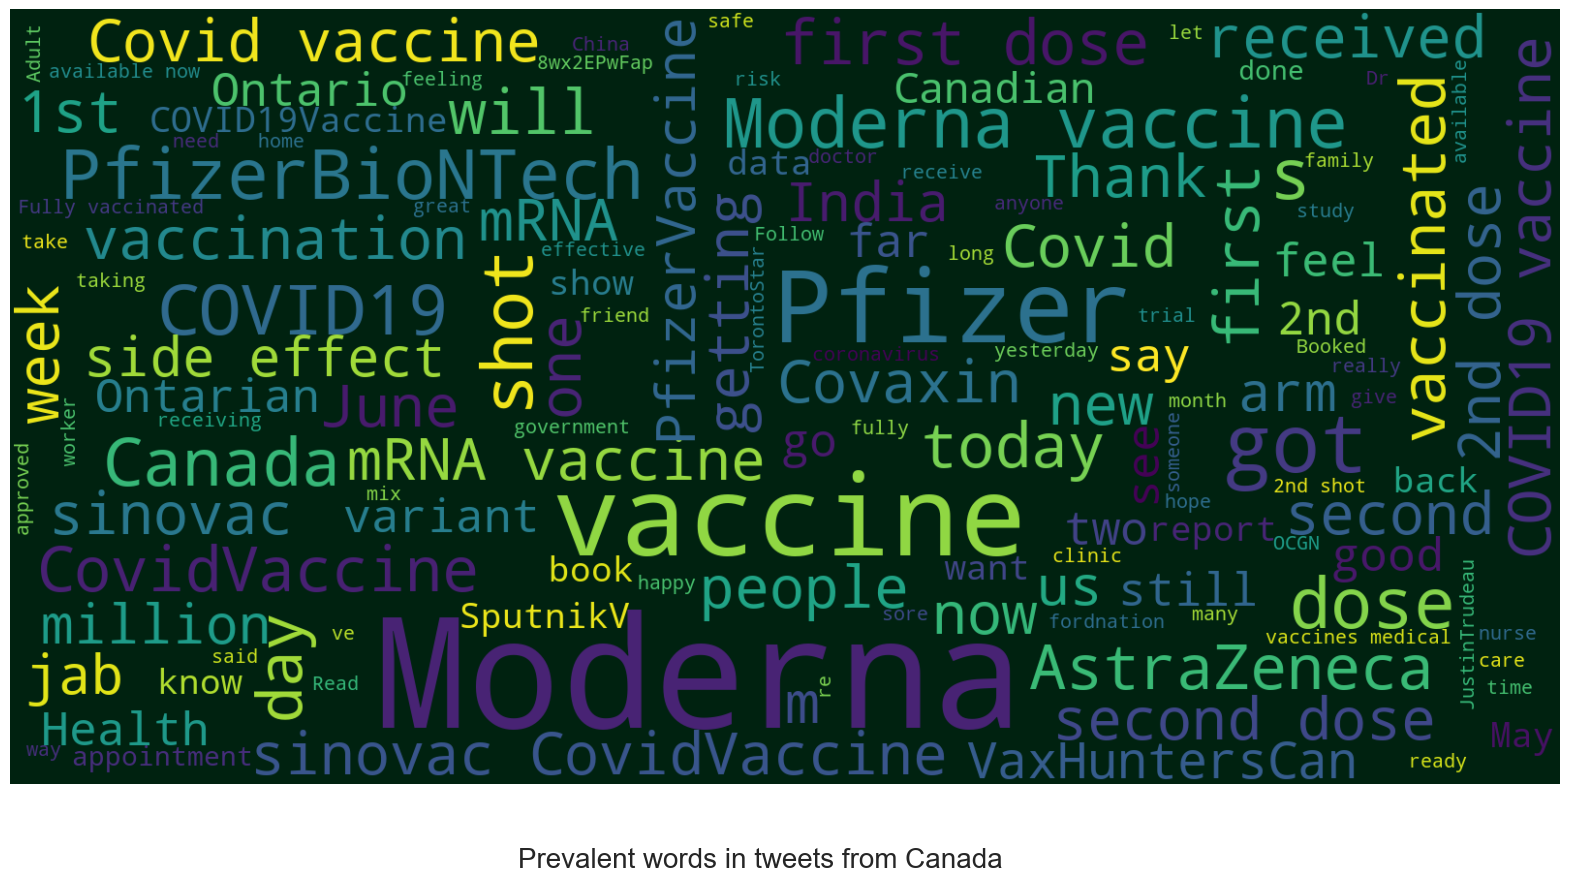

In [23]:
# From Canada
ca_df = tweets_df.loc[tweets_df.user_location=="Canada"]
show_wordcloud(ca_df['text'], title = 'Prevalent words in tweets from Canada')

**Hashtags Analysis**

In [24]:
def plot_features_distribution(features, title, df, isLog=False):
    plt.figure(figsize=(12,6))
    plt.title(title)
    for feature in features:
        if(isLog):
            sns.distplot(np.log1p(df[feature]),kde=True,hist=False, bins=120, label=feature,color='blue')
        else:
            sns.distplot(df[feature],kde=True, hist=False, bins=120, label=feature,color='blue')
    plt.xlabel('')
    plt.legend()
    plt.show()

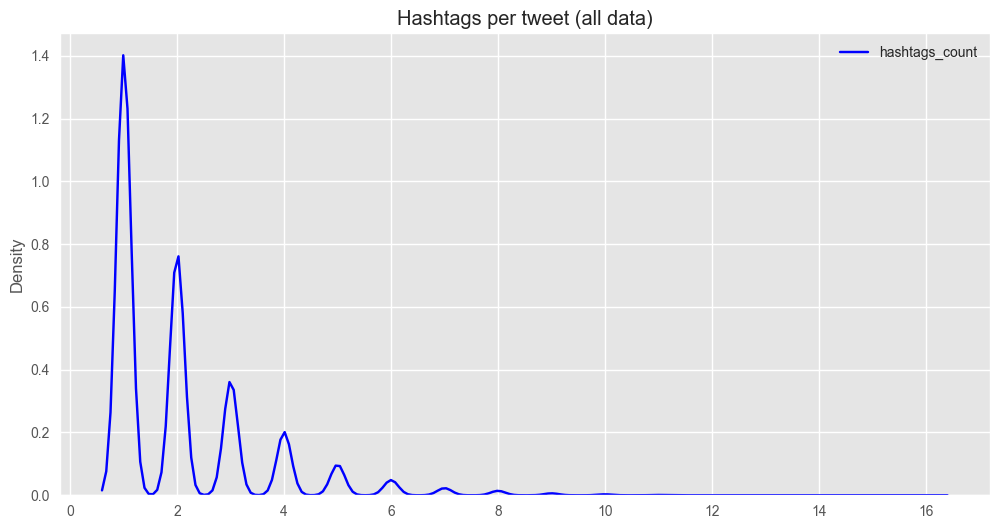

In [25]:
tweets_df['hashtags'] = tweets_df['hashtags'].replace(np.nan, "['None']", regex=True)
tweets_df['hashtags'] = tweets_df['hashtags'].apply(lambda x: x.replace('\\N',''))
tweets_df['hashtags_count'] = tweets_df['hashtags'].apply(lambda x: len(x.split(',')))
plot_features_distribution(['hashtags_count'], 'Hashtags per tweet (all data)', tweets_df)

In [26]:
tweets_df['hashtags_individual'] = tweets_df['hashtags'].apply(lambda x: x.split(','))
from itertools import chain
all_hashtags = set(chain.from_iterable(list(tweets_df['hashtags_individual'])))
print(f"There are totally Hastags of : {len(all_hashtags)}")

There are totally Hastags of : 28938


In [27]:
tweets_df['datedt'] = pd.to_datetime(tweets_df['date'])
tweets_df['year'] = tweets_df['datedt'].dt.year
tweets_df['month'] = tweets_df['datedt'].dt.month
tweets_df['day'] = tweets_df['datedt'].dt.day
tweets_df['dayofweek'] = tweets_df['datedt'].dt.dayofweek
tweets_df['hour'] = tweets_df['datedt'].dt.hour
tweets_df['minute'] = tweets_df['datedt'].dt.minute
tweets_df['dayofyear'] = tweets_df['datedt'].dt.dayofyear
tweets_df['date_only'] = tweets_df['datedt'].dt.date

In [28]:
tweets_agg_df = tweets_df.groupby(["date_only"])["text"].count().reset_index()
tweets_agg_df.columns = ["date_only", "count"]

In [29]:
def plot_time_variation(df, x='date_only', y='count', hue=None, size=1, title="", is_log=False):
    f, ax = plt.subplots(1,1, figsize=(4*size,3*size))
    g = sns.lineplot(x=x, y=y, hue=hue, data=df)
    plt.xticks(rotation=90)
    if hue:
        plt.title(f'{y} grouped by {hue} | {title}')
    else:
        plt.title(f'{y} | {title}')
    if(is_log):
        ax.set(yscale="log")
    ax.grid(color='black', linestyle='dotted', linewidth=0.75)
    plt.show() 

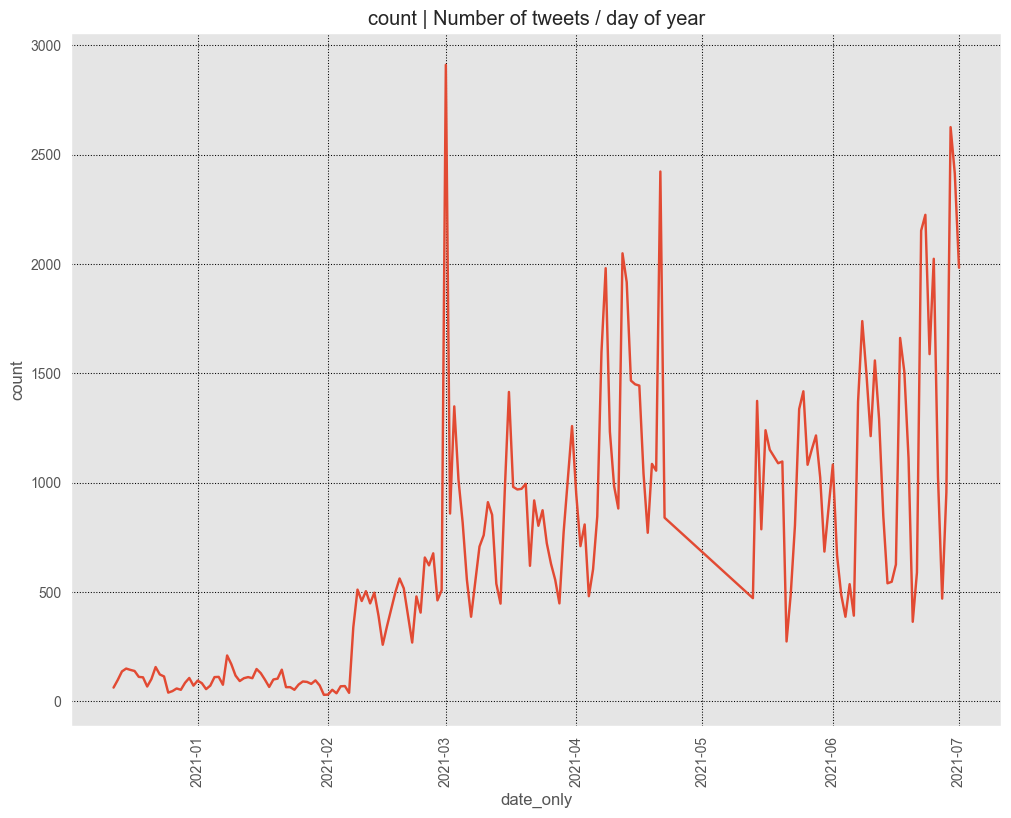

In [30]:
plot_time_variation(tweets_agg_df, title="Number of tweets / day of year",size=3)

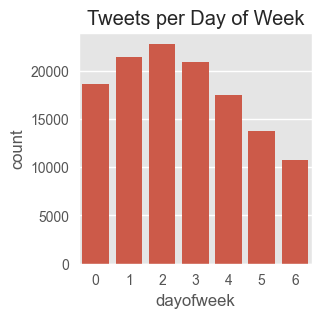

In [31]:
#plot_count("dayofweek", "tweets / day of week", tweets_df, size=3, ordered=False)
import seaborn as sns
import matplotlib.pyplot as plt

def plot_count(column, title, dataframe, size=3, ordered=True):
    plt.figure(figsize=(size, size))
    
    if ordered:
        order = dataframe[column].value_counts().index
    else:
        order = None
    
    sns.countplot(x=column, data=dataframe, order=order)
    
    plt.title(title)
    plt.show()

# Assuming 'dayofweek' is a column in your DataFrame
plot_count("dayofweek", "Tweets per Day of Week", tweets_df, size=3, ordered=False)


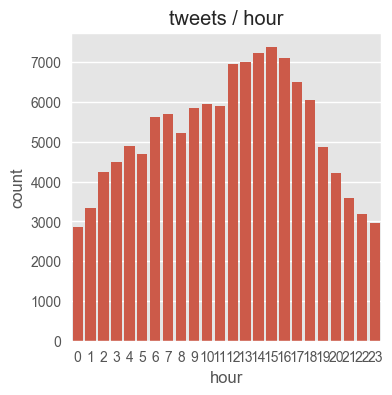

In [32]:
plot_count("hour", "tweets / hour", tweets_df,size=4, ordered=False)

**Pre-processing Of Our Dataset**

In [33]:
'''
The next steps about data cleaning will be:
- Remove URLs from the tweets
- Tokenize text
- Remove emails
- Remove new lines characters
- Remove distracting single quotes
- Remove all punctuation signs
- Lowercase all text
- Detokenize text
- Convert list of texts to Numpy array
'''
def depure_data(data):
    
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)

    # Remove dpunctuation signs
    data = re.sub("#", " ", data)


        
    return data

In [34]:
temp = []
#Splitting pd.Series to list
data_to_list = tweets_df["text"].values.tolist()
for i in range(len(data_to_list)):
    temp.append(depure_data(data_to_list[i]))
list(temp[:30])

['Same folks said daikon paste could treat a cytokine storm  PfizerBioNTech ',
 'While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort weve ev… ',
 ' coronavirus  SputnikV  AstraZeneca  PfizerBioNTech  Moderna  Covid_19 Russian vaccine is created to last 2-4 years… ',
 'Facts are immutable, Senator, even when youre not ethically sturdy enough to acknowledge them. (1) You were born i… ',
 'Explain to me again why we need a vaccine  whereareallthesickpeople  PfizerBioNTech… ',
 'Does anyone have any useful advice/guidance for whether the COVID vaccine is safe whilst breastfeeding?… ',
 'it is a bit sad to claim the fame for success of  vaccination on patriotic competition between USA, Canada, UK and… ',
 'There have not been many bright days in 2020 but here are some of the best 1.  BidenHarris winning  Election2020… ',
 'Covid vaccine; You getting it?  CovidVaccine  covid19  PfizerBioNTech  Moderna',
 ' CovidVaccine States will start 

In [35]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        

data_words = list(sent_to_words(temp))
print(data_words[:10],'\n')

[['same', 'folks', 'said', 'daikon', 'paste', 'could', 'treat', 'cytokine', 'storm', 'pfizerbiontech'], ['while', 'the', 'world', 'has', 'been', 'on', 'the', 'wrong', 'side', 'of', 'history', 'this', 'year', 'hopefully', 'the', 'biggest', 'vaccination', 'effort', 'weve', 'ev'], ['coronavirus', 'sputnikv', 'astrazeneca', 'pfizerbiontech', 'moderna', 'covid_', 'russian', 'vaccine', 'is', 'created', 'to', 'last', 'years'], ['facts', 'are', 'immutable', 'senator', 'even', 'when', 'youre', 'not', 'ethically', 'sturdy', 'enough', 'to', 'acknowledge', 'them', 'you', 'were', 'born'], ['explain', 'to', 'me', 'again', 'why', 'we', 'need', 'vaccine', 'pfizerbiontech'], ['does', 'anyone', 'have', 'any', 'useful', 'advice', 'guidance', 'for', 'whether', 'the', 'covid', 'vaccine', 'is', 'safe', 'whilst', 'breastfeeding'], ['it', 'is', 'bit', 'sad', 'to', 'claim', 'the', 'fame', 'for', 'success', 'of', 'vaccination', 'on', 'patriotic', 'competition', 'between', 'usa', 'canada', 'uk', 'and'], ['there'

In [36]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))
print(data[:5])

['same folks said daikon paste could treat cytokine storm pfizerbiontech', 'while the world has been on the wrong side of history this year hopefully the biggest vaccination effort weve ev', 'coronavirus sputnikv astrazeneca pfizerbiontech moderna covid_ russian vaccine is created to last years', 'facts are immutable senator even when youre not ethically sturdy enough to acknowledge them you were born', 'explain to me again why we need vaccine pfizerbiontech']


In [37]:
data = np.array(data)
#Create a sentiment column
tweets_df["sentiment"] = np.nan

In [38]:
# borrowed from https://www.kaggle.com/pashupatigupta/sentiments-transformer-vader-embedding-bert
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()
def find_sentiment(post):
    if sia.polarity_scores(post)["compound"] > 0:
        return "Positive"
    elif sia.polarity_scores(post)["compound"] < 0:
        return "Negative"
    else:
        return "Neutral" 

[nltk_data] Downloading package vader_lexicon to C:\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [39]:
tweets_df['sentiment'] = tweets_df['text'].apply(lambda x: find_sentiment(x))
tweets_df.head(25)

id              user_name                user_location  \
0   1340539111971516416             Rachel Roh    La Crescenta-Montrose, CA   
1   1338158543359250433            Albert Fong            San Francisco, CA   
2   1337858199140118533               eli🇱🇹🇪🇺👌                     Your Bed   
3   1337855739918835717          Charles Adler       Vancouver, BC - Canada   
4   1337854064604966912   Citizen News Channel                          NaN   
5   1337852648389832708                    Dee          Birmingham, England   
6   1337851215875608579      Gunther Fehlinger  Austria, Ukraine and Kosovo   
7   1337850832256176136    Dr.Krutika Kuppalli                          NaN   
8   1337850023531347969            Erin Despas                          NaN   
9   1337842295857623042           Ch.Amjad Ali                    Islamabad   
10  1337841934170255365            Tamer Yazar                Turkey-Israel   
11  1337840331522453507                 VoiceM                          NaN   
12  1337815730486702087                   WION                        India   
13  1337809196453081088    Dr.Krutika Kuppalli                          NaN   
14  1337807109010780162                  Opoyi                          NaN   
15  1337789467038523394              City A.M.              London, England   
16  1337789191598575616     STOPCOMMONPASS.ORG                       Global   
17  1337783770070409218                  ILKHA                      Türkiye   
18  1337781178665816064  Braderz73🌹#GTTO 🇪🇺 🇬🇧                  Bristol, UK   
19  1337776763384958976               Alex Vie              Los Angeles, CA   
20  1337774279862185986                   Mani                          NaN   
21  1337774059237629952      Richard Dunne, MD                Rochester, NY   
22  1337773965595598848              City A.M.              London, England   
23  1337773751841144833              BOOM Live                Mumbai, India   
24  1337770798770081796        DOCNOS Official                          NaN   

                                     user_description         user_created  \
0   Aggregator of Asian American news; scanning di...  2009-04-08 17:52:46   
1   Marketing dude, tech geek, heavy metal & '80s ...  2009-09-21 15:27:30   
2                                      heil, hydra 🖐☺  2020-06-25 23:30:28   
3   Hosting "CharlesAdlerTonight" Global News Radi...  2008-09-10 11:28:53   
4   Citizen News Channel bringing you an alternati...  2020-04-23 17:58:42   
5   Gastroenterology trainee, Clinical Research Fe...  2020-01-26 21:43:12   
6   End North Stream 2 now - the pipeline of corru...  2013-06-10 17:49:22   
7   ID, Global Health, VHF, Pandemic Prep, Emergin...  2019-03-25 04:14:29   
8   Designing&selling on Teespring. Like 90s Disne...  2009-10-30 17:53:54   
9   #ProudPakistani #LovePakArmy #PMIK @insafiansp...  2012-11-12 04:18:12   
10  Im Market Analyst, also Editor... working (fre...  2009-09-17 16:45:16   
11                    campaigner & optimistic realist  2020-08-31 10:38:21   
12  #WION: World Is One | Welcome to India’s first...  2016-03-21 03:44:54   
13  ID, Global Health, VHF, Pandemic Prep, Emergin...  2019-03-25 04:14:29   
14  High-quality trusted conversations around news...  2019-01-13 18:33:22   
15  London's business newspaper - News, Opinion, a...  2009-06-09 13:53:06   
16  'Trust' is not carte-blanche for erosion of ou...  2020-10-25 20:33:33   
17     Official Twitter account of Ilke News Agency /  2015-05-22 08:31:12   
18  One of those lefty types, I believe in a faire...  2012-07-24 08:18:51   
19  Marine vet. Yogi. Krav Maga. Runner. Climber. ...  2010-01-24 04:43:57   
20                                                NaN  2019-10-10 13:41:10   
21  Husband, Girl Dad, GI Oncologist @wilmotcancer...  2012-04-23 12:18:55   
22  London's business newspaper - News, Opinion, a...  2009-06-09 13:53:06   
23  IFCN certified fact-driven journalism. India's...  2014-03-16 03:52:50   
24  An Innovativ

In [40]:
pos = tweets_df['sentiment'].value_counts()
print(pos)

sentiment
Neutral     61048
Positive    42759
Negative    22099
Name: count, dtype: int64


In [41]:
def plot_sentiment(df, feature, title):
    counts = df[feature].value_counts()
    percent = counts/sum(counts)
    print(percent,"\n")
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

    counts.plot(kind='bar', ax=ax1, color='green')
    percent.plot(kind='bar', ax=ax2, color='blue')
    ax1.set_ylabel(f'Counts : {title} sentiments', size=12)
    ax2.set_ylabel(f'Percentage : {title} sentiments', size=12)
    plt.suptitle(f"Sentiment analysis: {title}\n")  
    plt.tight_layout()
    plt.show()

sentiment
Neutral     0.484870
Positive    0.339611
Negative    0.175520
Name: count, dtype: float64 



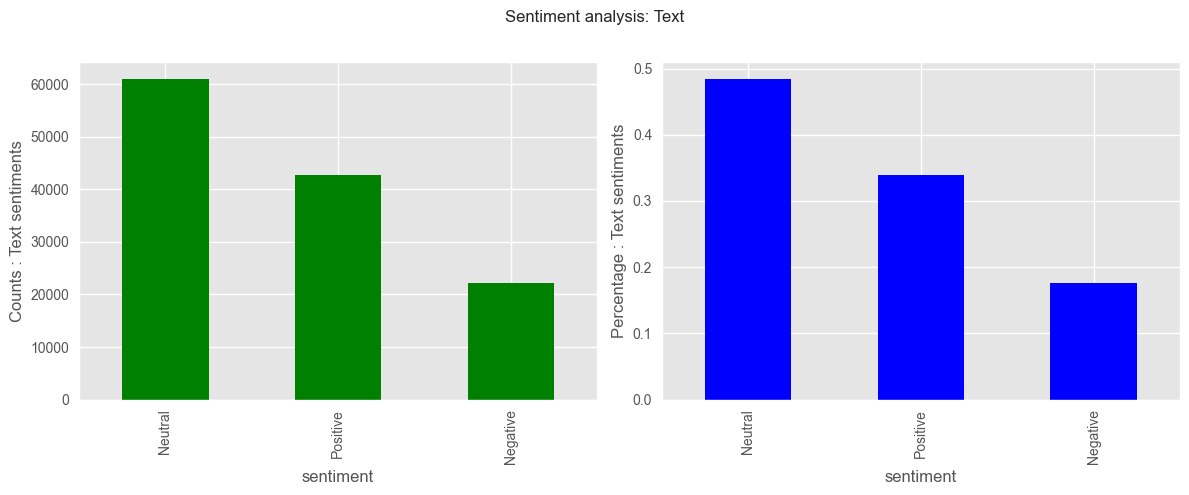

In [42]:
plot_sentiment(tweets_df, 'sentiment', 'Text')

In [43]:
# Label Encoding
labels = np.array(tweets_df["sentiment"])
y = []
for i in range(len(labels)):
    if labels[i] == 'Neutral':
        y.append(0)
    if labels[i] == 'Negative':
        y.append(1)
    if labels[i] == "Positive":
        y.append(2)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

**Data sequencing and splitting**

In [44]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint


In [45]:
#Conver the word to vec
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...  240 3032   53]
 [   0    0    0 ... 1624 1917 3554]
 [   0    0    0 ...    3  198  312]
 ...
 [   0    0    0 ...   15  632  407]
 [   0    0    0 ...    3   15 4113]
 [   0    0    0 ...  235 1479  657]]


In [46]:
print(labels)

[[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [47]:
#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(tweets,labels, random_state=0)
print (f"Our data split form:\n")
print(f"X_train: ",len(X_train))
print(f"X_test: ",len(X_test))
print(f"y_train: ",len(y_train))
print(f"y_test: ", len(y_test))

Our data split form:

X_train:  94429
X_test:  31477
y_train:  94429
y_test:  31477


**Single LSTM**

In [ ]:
model1 = Sequential()
model1.add(layers.Embedding(max_words, 20))
model1.add(layers.LSTM(15,dropout=0.5))
model1.add(layers.Dense(3,activation='softmax'))


model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history1 = model1.fit(X_train, y_train, epochs=10,validation_data=(X_test, y_test),callbacks=[checkpoint1])



Epoch 1/10


2951/2951 [==============================] - ETA: 0s - loss: 0.6451 - accuracy: 0.7269
Epoch 1: val_accuracy improved from -inf to 0.84119, saving model to best_model1.hdf5
2951/2951 [==============================] - 205s 67ms/step - loss: 0.6451 - accuracy: 0.7269 - val_loss: 0.4447 - val_accuracy: 0.8412
Epoch 2/10
2951/2951 [==============================] - ETA: 0s - loss: 0.3945 - accuracy: 0.8629
Epoch 2: val_accuracy improved from 0.84119 to 0.88760, saving model to best_model1.hdf5
2951/2951 [==============================] - 177s 60ms/step - loss: 0.3945 - accuracy: 0.8629 - val_loss: 0.3455 - val_accuracy: 0.8876
Epoch 3/10
2951/2951 [==============================] - ETA: 0s - loss: 0.3352 - accuracy: 0.8931
Epoch 3: val_accuracy improved from 0.88760 to 0.90031, saving model to best_model1.hdf5
2951/2951 [==============================] - 160s 54ms/step - loss: 0.3352 - accuracy: 0.8931 - val_loss: 0.3152 - val_accuracy: 0.9003
Epoch 4/10
2950/2951 [========

In [ ]:
# summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('LSTM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# summarize history for accuracy
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title(' LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
best_model = keras.models.load_model("./best_model1.hdf5")

In [ ]:
lstmpredict = model1.predict(X_test)
print(lstmpredict)

In [ ]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

In [ ]:
test_loss, test_acc = best_model.evaluate(lstmpredict, y_test, verbose=2)
print('Model accuracy: ',test_acc)

In [ ]:
# Plot the classification_report 
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1),np.argmax(lstmpredict, axis=1)))

**Bidirectional LSTM**

In [ ]:
model = Sequential()
model.add(layers.Embedding(max_words, 40, input_length=max_len))
model.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model.add(layers.Dense(3,activation='softmax'))

# Compile the model
model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
# Save the Modek
checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
# Train the Model
history = model.fit(X_train, y_train, epochs=10,validation_data=(X_test, y_test),callbacks=[checkpoint2])

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('BiLSTM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('BiLSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
best_model = keras.models.load_model("./best_model2.hdf5")

In [ ]:
predictions = best_model.predict(X_test)
print(predictions)

In [ ]:
# Assuming predictions is a 1D array
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)


In [ ]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print(' Best Model accuracy: ',test_acc)

In [ ]:
# Plot the classification_report 
#from sklearn.metrics import classification_report
#print(classification_report(np.argmax(y_test, axis=1),np.argmax(predictions, axis=1)))

In [ ]:
#matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))
#conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])

#Normalizing
#conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
#plt.figure(figsize = (15,15))
#seaborn.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})


**Let's check if the model can predict** 

In [ ]:
sentiment = ['Neutral','Negative','Positive']

In [ ]:
sequence = tokenizer.texts_to_sequences(['the trump administration failed to deliver on vaccine promises shocker covidiots coronavirus covidvaccine'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

In [ ]:
sequence = tokenizer.texts_to_sequences(['this data science article is the best ever'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

In [ ]:
sequence = tokenizer.texts_to_sequences(['Facts are immutable Senator even when youre not ethically sturdy enough to acknowledge them.'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

**Visualisation About the Vaccine**

In [ ]:
# Convert dates
tweets_df['date'] = pd.to_datetime(tweets_df['date'], errors='coerce').dt.date

# Get counts of number of tweets by sentiment for each date
timeline = tweets_df.groupby(['date', 'sentiment']).agg(**{'tweets': ('id', 'count')}).reset_index().dropna()

fig = px.line(timeline, x='date', y='tweets', color='sentiment', color_discrete_sequence=["#EF553B", "#636EFA", "#00CC96"], category_orders={'sentiment': ['neutral', 'negative', 'positive']},
             title='Timeline showing sentiment of tweets about COVID-19 vaccines')
fig.show()

In [ ]:
show_wordcloud(tweets_df.loc[tweets_df['sentiment']=='Positive', 'text'], title = 'Prevalent words in tweets (Positive sentiment)')

In [ ]:
show_wordcloud(tweets_df.loc[tweets_df['sentiment']=='Neutral', 'text'], title = 'Prevalent words in tweets (Neutral sentiment)')

In [ ]:
show_wordcloud(tweets_df.loc[tweets_df['sentiment']=='Negative', 'text'], title = 'Prevalent words in tweets (Negative sentiment)')

END